# Tingle SED Fitting/Analysis Sample

In [1]:
from plot_fit import *
from table_loading import *

## SED Fitting

This notebook is set up to demonstrate fitting and plot creation for a single source. The Tingle SED Fitter notebook is set up to fit sources per-region.

In [2]:
# get rid of ALMA points for comparison?
almaoverride = False

# select SPICY source(s) of interest (must be in the ALMA-IMF+SPICY sample)
sources_to_fit = [30416]

In [3]:
all_fitinfo = {}

for spicyid in tqdm(sources_to_fit):
    
    fieldid = field_lookup(spicyid)
    print("Field: ",fieldid)

    # load table from Table Prep notebook
    tbl = Table.read(f'/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/Region_tables/Unfitted/{fieldid}', format='fits') # !filepath!

    if almaoverride:
        for x in ['ALMA-IMF_3mm_flux','ALMA-IMF_3mm_eflux','ALMA-IMF_1mm_flux','ALMA-IMF_1mm_eflux']:
            tbl[x] = 0
            tbl[x] = np.nan
            tbl[x] = np.ma.masked

    # define constant sizes, based on literature values
    apertures = [2.4, 2.4, 2.4, 2.4, 6, 10, 13.5, 23, 30, 41, 3, 3]*u.arcsec
    
    # determine filters and add aperture sizes based on whether we're using UKDISS or VIRAC data
    ukidss_fields = ['G10','G12','W43MM1','W43MM2','W43MM3','W51-E','W51IRS2']
    virac_fields = ['G008','G327','G328','G333','G337','G338','G351','G353']
    
    if any(x in virac_fields for x in tbl['ALMAIMF_FIELDID']):
        print("Grabbing VIRAC filters")
        sed_filters, wavelength_dict, filternames, zpts = get_filters("south")
        apertures = apertures.insert(0,[1.415, 1.415, 1.415, 1.415, 1.415]*u.arcsec)
        hemisphere = "south"
    elif any(x in ukidss_fields for x in tbl['ALMAIMF_FIELDID']):
        print("Grabbing UKIDSS filters")
        sed_filters, wavelength_dict, filternames, zpts = get_filters("north")
        apertures = apertures.insert(0,[2, 2, 2]*u.arcsec)
        hemisphere = "north"
    print("Filters:"+str(filternames))
    print("Apertures:"+str(apertures))

    # read distance from table (in kpc)
    regiondistance = np.nanmax(tbl['Distance'])
    print("Region literature distance (kpc): "+str(regiondistance))
    
    # infer allowable distance range (in kpc)
    distance_range=[regiondistance-0.2, regiondistance+0.2]
    print("Distance range (kpc):"+str(distance_range))
    
    # determine appropriate extinction, using 2*region distance as a lower bound
    av_range=[regiondistance*2,60]
    print("Extinction range (kpc): "+str(av_range))
    
    # make extinction law
    extinction = make_extinction()
    
    # run fitting on each source in region, store data to an array
    
    tbl.add_index('SPICY')
    rownum = tbl.loc_indices[spicyid]
    
    fits = full_source_fit(tbl, rownum, filternames, apertures, 
                           '/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/robitaille_models', 
                           extinction, distance_range*u.kpc, av_range) # !filepath!
    
    # append fit data to data array
    all_fitinfo[tbl['SPICY'][rownum]] = fits

  0%|          | 0/1 [00:00<?, ?it/s]

Field:  G327
Grabbing VIRAC filters
Filters:['Paranal/VISTA.Y', 'Paranal/VISTA.Z', 'Paranal/VISTA.J', 'Paranal/VISTA.H', 'Paranal/VISTA.Ks', 'Spitzer/IRAC.I1', 'Spitzer/IRAC.I2', 'Spitzer/IRAC.I3', 'Spitzer/IRAC.I4', 'Spitzer/MIPS.24mu', 'Herschel/Pacs.blue', 'Herschel/Pacs.red', 'Herschel/SPIRE.PSW', 'Herschel/SPIRE.PMW', 'Herschel/SPIRE.PLW']
Apertures:[ 1.415  1.415  1.415  1.415  1.415  2.4    2.4    2.4    2.4    6.
 10.    13.5   23.    30.    41.     3.     3.   ] arcsec
Region literature distance (kpc): 2.5
Distance range (kpc):[2.3, 2.7]
Extinction range (kpc): [5.0, 60]


Fitting source 4/6:   0%|          | 0/18 [00:00<?, ?it/s]

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s-pbhmi
   Log[d] stepping     :  0.02
   Number of distances :  5

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(90000, 5, 17).  use_memmap=True
   Reading /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/robitaille_models/s-pbhmi/convolved/Paranal/VISTA.Y.fits
   Reading /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/robitaille_models/s-pbhmi/convolved/Paranal/VISTA.Z.fits
   Reading /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/robitaille_models/s-pbhmi/convolved/Paranal/VISTA.J.fits
   Reading /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/robitaille_models/s-pbhmi/convolved/Paranal/VISTA.H.fits
   Reading /blue/adamginsburg/adamginsburg/SPICY_ALMA

In [4]:
fitinfo_tbl = construct_fitinfo_tbl(all_fitinfo)

  0%|          | 0/1 [00:00<?, ?it/s]

30416


  0%|          | 0/18 [00:00<?, ?it/s]

In [5]:
fitinfo_tbl.write(f'/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/fit_results', format='fits', overwrite=True)

# Using plot_fit

In [6]:
fit_rslt = Table.read('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/fit_results')

In [7]:
fit_results = deconstruct_fitinfo_tbl(fit_rslt)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

30416
Success


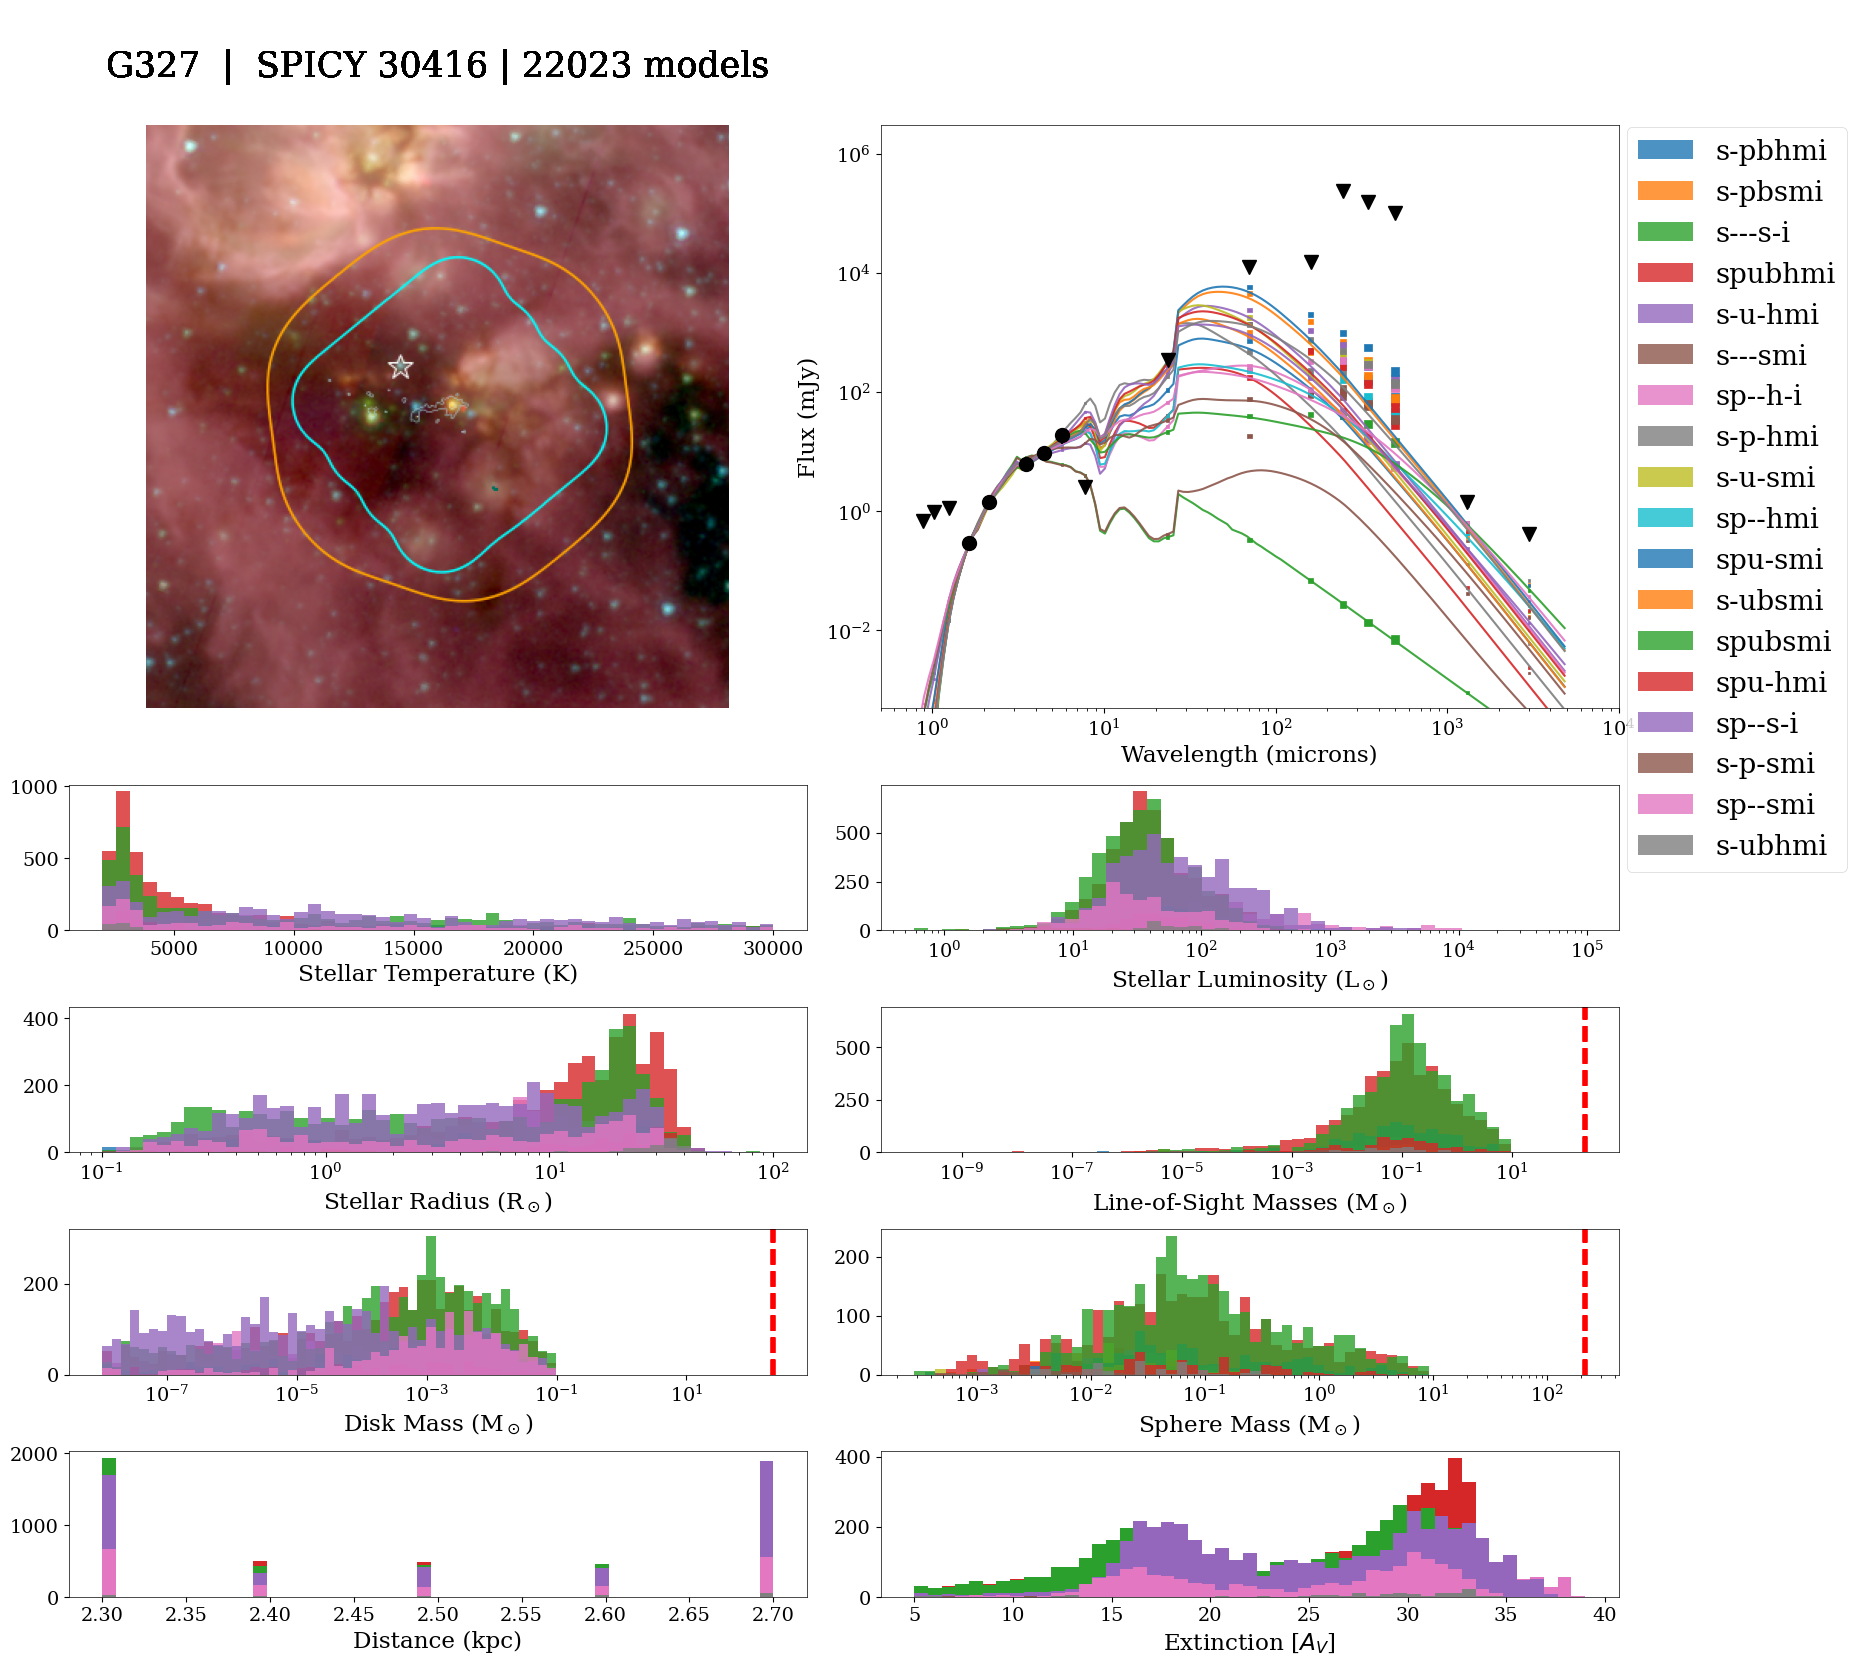

In [8]:
for spicyid in tqdm(fit_results.keys()):
    fig = None
    print(spicyid)
    fieldid = field_lookup(spicyid)
    fig = plot_fit(spicyid, fit_results)
    fig.savefig(f'/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/BriceTingle/SED_plots/{fieldid}_{spicyid}.jpg', format="jpg")
    print("Success")